In [1]:
from google.colab import files

uploaded = files.upload()

Saving salesweekly.csv to salesweekly.csv


In [2]:
import warnings

import numpy as np
from numpy import array
import pandas as pd
from pandas import concat
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import ParameterGrid

pd.plotting.register_matplotlib_converters()

warnings.filterwarnings("ignore")

import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [3]:
pip install pmdarima


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 32.5 MB/s eta 0:00:00


In [5]:
import statsmodels.api as sm
df = pd.read_csv('salesweekly.csv')
warnings.filterwarnings("ignore")
for x in ['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06']:
    resDiff = sm.tsa.arma_order_select_ic(df[x], max_ar=5, max_ma=5, ic='aic', trend='c')
    print('ARMA(p,q,'+x+') =',resDiff['aic_min_order'],'is the best.')

ARMA(p,q,M01AB) = (np.int64(3), np.int64(3)) is the best.
ARMA(p,q,M01AE) = (np.int64(2), np.int64(0)) is the best.
ARMA(p,q,N02BA) = (np.int64(3), np.int64(3)) is the best.
ARMA(p,q,N02BE) = (np.int64(2), np.int64(2)) is the best.
ARMA(p,q,N05B) = (np.int64(4), np.int64(3)) is the best.
ARMA(p,q,N05C) = (np.int64(3), np.int64(2)) is the best.
ARMA(p,q,R03) = (np.int64(1), np.int64(1)) is the best.
ARMA(p,q,R06) = (np.int64(2), np.int64(2)) is the best.


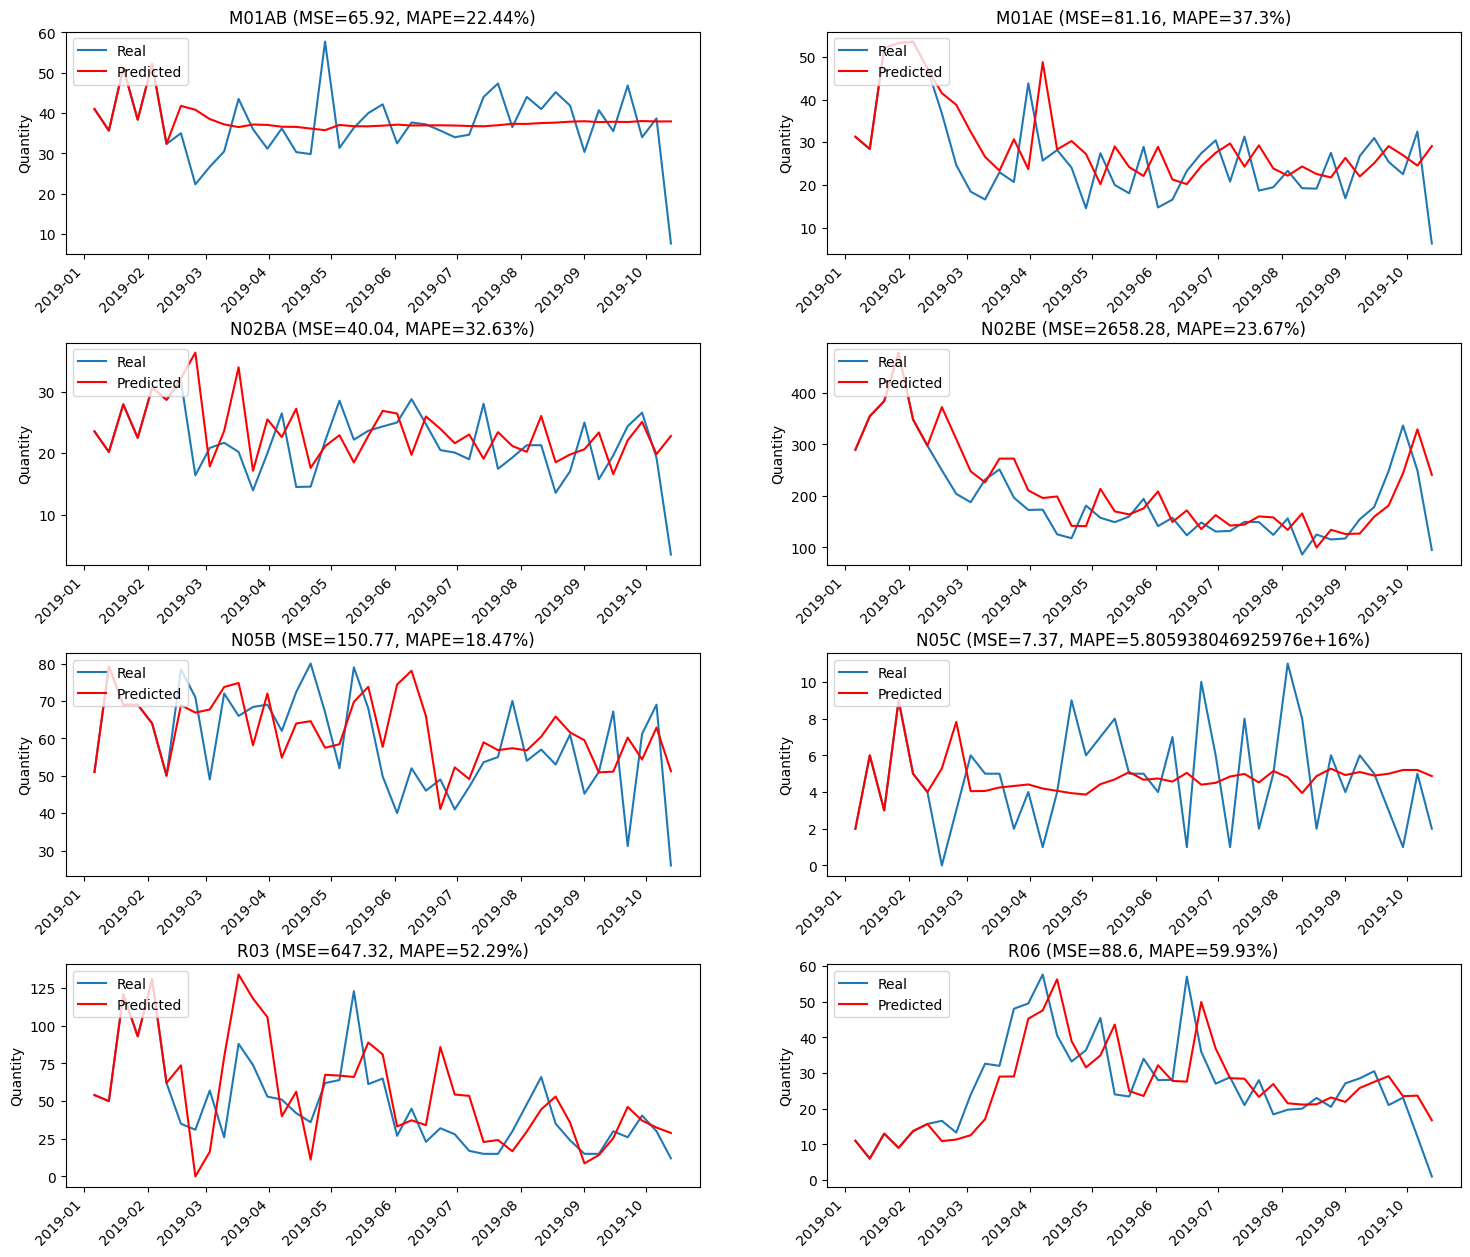


Results Summary:
                M01AB      M01AE      N02BA        N02BE        N05B  \
ARIMA MSE   65.921106  81.155518  40.040807  2658.282805  150.774779   
ARIMA MAPE   0.224410   0.372959   0.326319     0.236655    0.184725   

                    N05C         R03        R06  
ARIMA MSE   7.366251e+00  647.321798  88.603069  
ARIMA MAPE  5.805938e+14    0.522929   0.599263  


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math
import warnings
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

df = pd.read_csv("salesweekly.csv", parse_dates=["datum"])
df = df.rename(columns={"datum": "Date"})
df = df.set_index("Date")
df = df.loc["2019-01":"2019-10"]

M01AB= {'series':'M01AB','p':0,'d':0,'q':0}
M01AE= {'series':'M01AE','p':2,'d':0,'q':0}
N02BA= {'series':'N02BA','p':5,'d':1,'q':1}
N02BE= {'series':'N02BE','p':2,'d':0,'q':0}
N05B= {'series':'N05B','p':0,'d':0,'q':5}
N05C= {'series':'N05C','p':0,'d':0,'q':1}
R03= {'series':'R03','p':5,'d':1,'q':1}
R06= {'series':'R06','p':1,'d':0,'q':1}

resultsRollingdf = pd.DataFrame()
subplotindex=0
numrows=4
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,15))
plt.subplots_adjust(wspace=0.2, hspace=0.4)
warnings.filterwarnings("ignore")

for config in [M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06]:
    rowindex = math.floor(subplotindex/numcols)
    colindex = subplotindex - (rowindex*numcols)

    series = df[config['series']].dropna()
    X = series.values
    dates = series.index
    history = []
    predictions = []

    for t in range(len(X)):
        if len(history) > 5:
            model = ARIMA(history, order=(config['p'], config['d'], config['q']))
            model_fit = model.fit()
            yhat = model_fit.forecast(steps=1)[0]
        else:
            yhat = X[t]
        predictions.append(yhat)
        history.append(X[t])

    error = mean_squared_error(X, predictions)
    perror = mean_absolute_percentage_error(X, predictions)

    resultsRollingdf.loc['ARIMA MSE',config['series']] = error
    resultsRollingdf.loc['ARIMA MAPE',config['series']] = perror

    ax[rowindex,colindex].set_title(
        f"{config['series']} (MSE={round(error,2)}, MAPE={round(perror*100,2)}%)"
    )
    ax[rowindex,colindex].plot(dates, X, label="Real")
    ax[rowindex,colindex].plot(dates, predictions, color="red", label="Predicted")
    ax[rowindex,colindex].legend(loc='upper left')
    #ax[rowindex,colindex].set_xlabel("2019 Jan–Oct")
    ax[rowindex,colindex].set_ylabel("Quantity")
    ax[rowindex,colindex].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax[rowindex,colindex].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    plt.setp(ax[rowindex,colindex].xaxis.get_majorticklabels(), rotation=45, ha="right")

    subplotindex += 1

plt.show()

print("\nResults Summary:")
print(resultsRollingdf)



Prediction Results for M01AB:
         Date  Actual  Predicted
0  2019-01-06   41.00  41.000000
1  2019-01-13   35.66  35.660000
2  2019-01-20   51.19  51.190000
3  2019-01-27   38.35  38.350000
4  2019-02-03   52.18  52.180000
5  2019-02-10   32.35  32.350000
6  2019-02-17   35.01  41.788328
7  2019-02-24   22.35  40.819995
8  2019-03-03   26.68  38.511245
9  2019-03-10   30.51  37.196662
10 2019-03-17   43.51  36.527995
11 2019-03-24   35.99  37.162722
12 2019-03-31   31.17  37.064995
13 2019-04-07   36.19  36.611533
14 2019-04-14   30.33  36.581423
15 2019-04-21   29.84  36.164662
16 2019-04-28   57.70  35.769370
17 2019-05-05   31.36  37.059407
18 2019-05-12   36.35  36.742773
19 2019-05-19   40.00  36.722100
20 2019-05-26   42.17  36.885995
21 2019-06-02   32.49  37.137614
22 2019-06-09   37.67  36.926359
23 2019-06-16   37.20  36.958691
24 2019-06-23   35.66  36.968745
25 2019-06-30   34.01  36.916395
26 2019-07-07   34.65  36.804611
27 2019-07-14   44.00  36.724810
28 2019-07-2

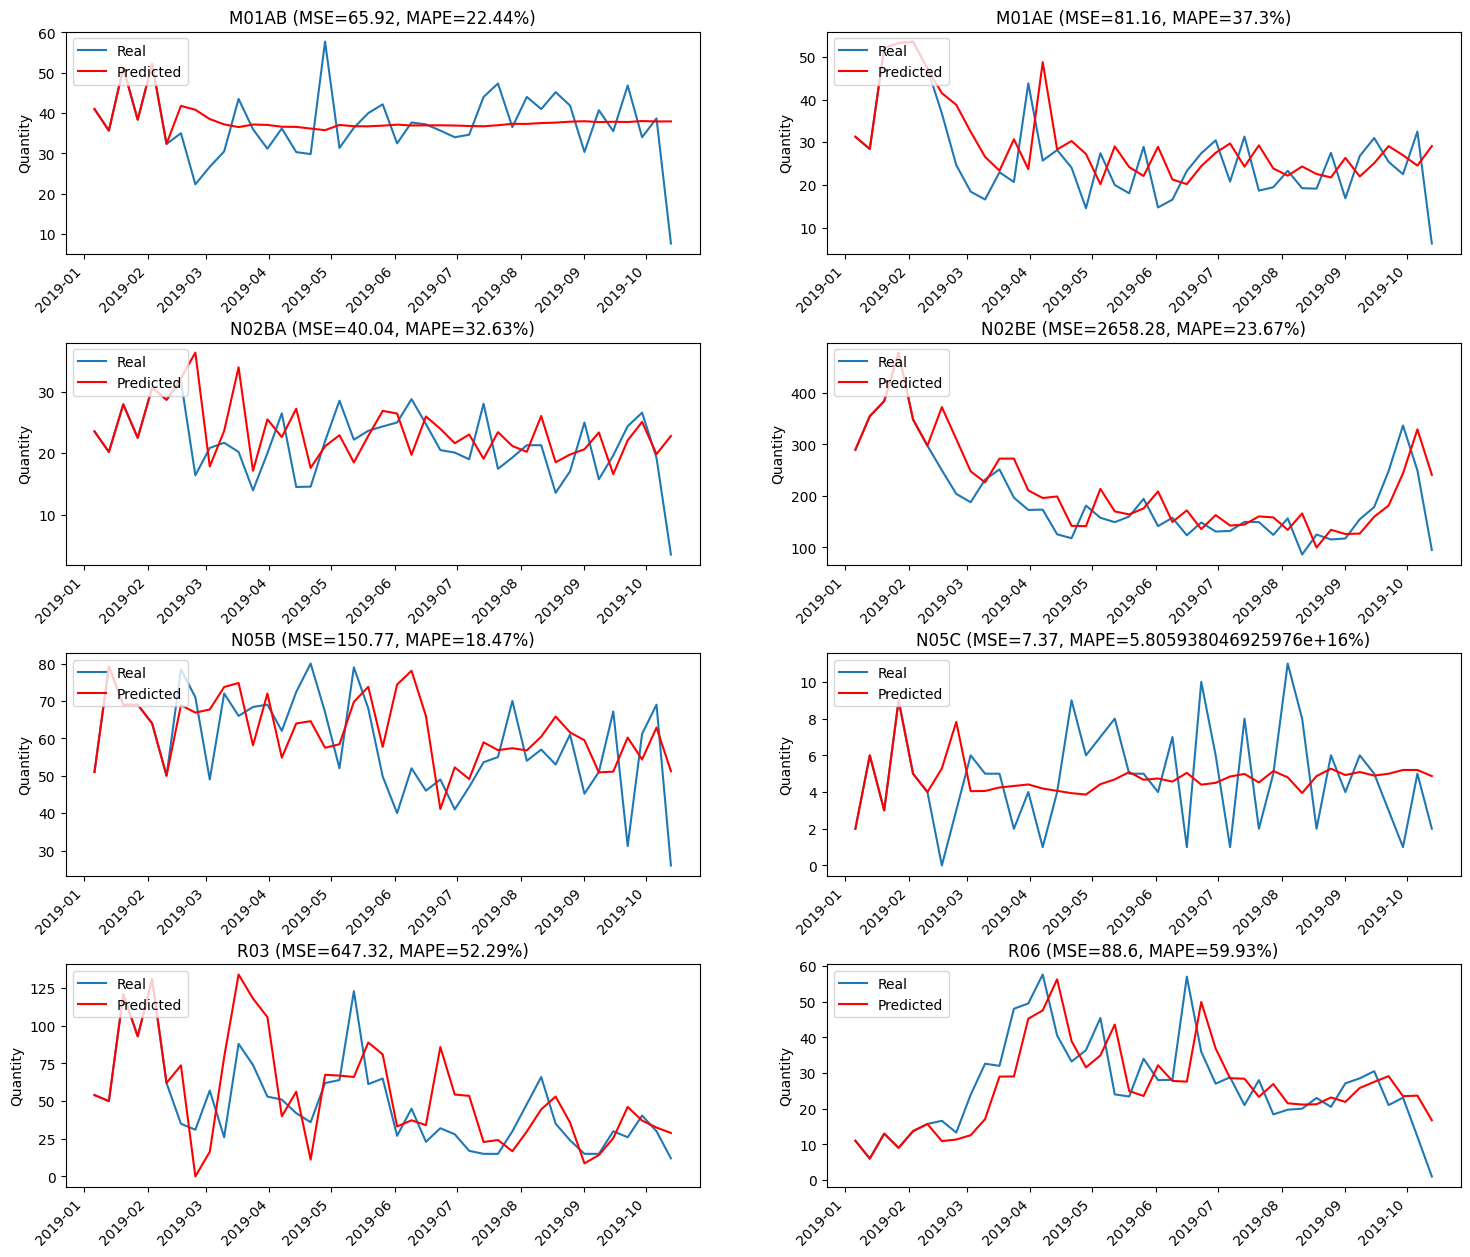


Results Summary:
                M01AB      M01AE      N02BA        N02BE        N05B  \
ARIMA MSE   65.921106  81.155518  40.040807  2658.282805  150.774779   
ARIMA MAPE   0.224410   0.372959   0.326319     0.236655    0.184725   

                    N05C         R03        R06  
ARIMA MSE   7.366251e+00  647.321798  88.603069  
ARIMA MAPE  5.805938e+14    0.522929   0.599263  

All Predictions Combined:
          Date  Actual  Predicted Series
0   2019-01-06   41.00  41.000000  M01AB
1   2019-01-13   35.66  35.660000  M01AB
2   2019-01-20   51.19  51.190000  M01AB
3   2019-01-27   38.35  38.350000  M01AB
4   2019-02-03   52.18  52.180000  M01AB
..         ...     ...        ...    ...
323 2019-09-15   30.50  27.503457    R06
324 2019-09-22   21.00  29.110754    R06
325 2019-09-29   23.10  23.499705    R06
326 2019-10-06   12.13  23.656902    R06
327 2019-10-13    1.00  16.750525    R06

[328 rows x 4 columns]


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math
import warnings
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Load dataset
df = pd.read_csv("salesweekly.csv", parse_dates=["datum"])
df = df.rename(columns={"datum": "Date"})
df = df.set_index("Date")
df = df.loc["2019-01":"2019-10"]

# ARIMA configurations for each drug
M01AB = {'series': 'M01AB', 'p': 0, 'd': 0, 'q': 0}
M01AE = {'series': 'M01AE', 'p': 2, 'd': 0, 'q': 0}
N02BA = {'series': 'N02BA', 'p': 5, 'd': 1, 'q': 1}
N02BE = {'series': 'N02BE', 'p': 2, 'd': 0, 'q': 0}
N05B  = {'series': 'N05B',  'p': 0, 'd': 0, 'q': 5}
N05C  = {'series': 'N05C',  'p': 0, 'd': 0, 'q': 1}
R03   = {'series': 'R03',   'p': 5, 'd': 1, 'q': 1}
R06   = {'series': 'R06',   'p': 1, 'd': 0, 'q': 1}

# Store metrics
resultsRollingdf = pd.DataFrame()
# Store predictions for all series
all_predictions = pd.DataFrame()

# Plot setup
subplotindex = 0
numrows = 4
numcols = 2
fig, ax = plt.subplots(numrows, numcols, figsize=(18, 15))
plt.subplots_adjust(wspace=0.2, hspace=0.4)
warnings.filterwarnings("ignore")

# Loop over configs
for config in [M01AB, M01AE, N02BA, N02BE, N05B, N05C, R03, R06]:
    rowindex = math.floor(subplotindex / numcols)
    colindex = subplotindex - (rowindex * numcols)

    series = df[config['series']].dropna()
    X = series.values
    dates = series.index
    history = []
    predictions = []

    # Rolling forecast
    for t in range(len(X)):
        if len(history) > 5:
            model = ARIMA(history, order=(config['p'], config['d'], config['q']))
            model_fit = model.fit()
            yhat = model_fit.forecast(steps=1)[0]
        else:
            yhat = X[t]
        predictions.append(yhat)
        history.append(X[t])

    # Store actual vs predicted in a DataFrame
    result_df = pd.DataFrame({
        "Date": dates,
        "Actual": X,
        "Predicted": predictions
    })

    # Print results for each series
    print(f"\nPrediction Results for {config['series']}:")
    print(result_df)

    # Add to combined predictions DataFrame
    temp = result_df.copy()
    temp["Series"] = config['series']
    all_predictions = pd.concat([all_predictions, temp], ignore_index=True)

    # Metrics
    error = mean_squared_error(X, predictions)
    perror = mean_absolute_percentage_error(X, predictions)
    resultsRollingdf.loc['ARIMA MSE', config['series']] = error
    resultsRollingdf.loc['ARIMA MAPE', config['series']] = perror

    # Plotting
    ax[rowindex, colindex].set_title(
        f"{config['series']} (MSE={round(error,2)}, MAPE={round(perror*100,2)}%)"
    )
    ax[rowindex, colindex].plot(dates, X, label="Real")
    ax[rowindex, colindex].plot(dates, predictions, color="red", label="Predicted")
    ax[rowindex, colindex].legend(loc='upper left')
    ax[rowindex, colindex].set_ylabel("Quantity")
    ax[rowindex, colindex].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax[rowindex, colindex].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    plt.setp(ax[rowindex, colindex].xaxis.get_majorticklabels(), rotation=45, ha="right")

    subplotindex += 1

# Show plots
plt.show()

# Print summary table
print("\nResults Summary:")
print(resultsRollingdf)

# Print all predictions together
print("\nAll Predictions Combined:")
print(all_predictions)

# (Optional) Save predictions to CSV
all_predictions.to_csv("all_predictions.csv", index=False)
